In [1]:
# Step 0: Install and Import
!pip install -q pandasql

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

pysqldf = lambda q: sqldf(q, globals())

  Preparing metadata (setup.py) ... done


In [2]:
# Load dataset
df_raw = pd.read_csv('/content/sample_data/mock_ecommerce_returns_dataset.csv')

In [3]:
# Use SQL to clean: remove nulls and select relevant fields
query_clean = """
SELECT *
FROM df_raw
WHERE price IS NOT NULL
  AND shipping_days IS NOT NULL
  AND customer_rating IS NOT NULL
"""
df = pysqldf(query_clean)

# Confirm cleaned data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          5000 non-null   object 
 1   product_id        5000 non-null   object 
 2   category          5000 non-null   object 
 3   region            5000 non-null   object 
 4   supplier          5000 non-null   object 
 5   channel           5000 non-null   object 
 6   customer_segment  5000 non-null   object 
 7   price             5000 non-null   float64
 8   shipping_days     5000 non-null   int64  
 9   customer_rating   5000 non-null   float64
 10  return_flag       5000 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 429.8+ KB
None


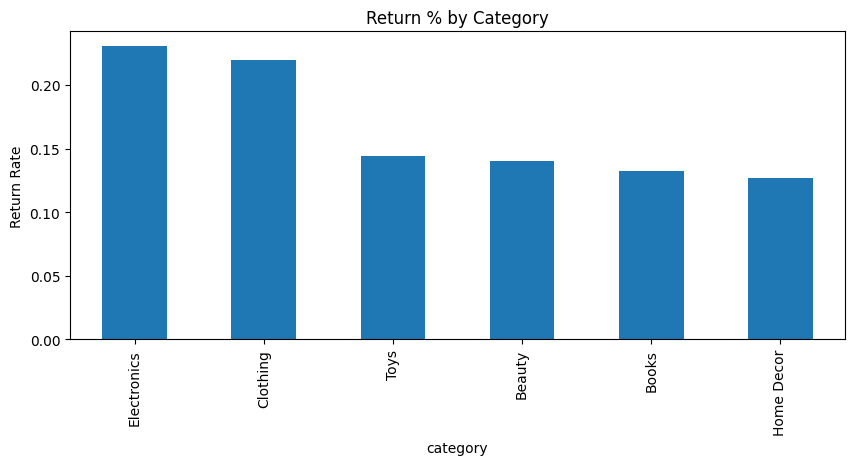

In [4]:
# Analyze Return %
category_return = df.groupby('category')['return_flag'].mean().sort_values(ascending=False)
category_return.plot(kind='bar', title='Return % by Category', ylabel='Return Rate', figsize=(10, 4))
plt.show()

In [5]:
# Logistic Regression Model
features = ['category', 'region', 'supplier', 'channel', 'customer_segment', 'price', 'shipping_days', 'customer_rating']
X = pd.get_dummies(df[features], drop_first=True)
y = df['return_flag']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       831
           1       0.00      0.00      0.00       169

    accuracy                           0.83      1000
   macro avg       0.42      0.50      0.45      1000
weighted avg       0.69      0.83      0.75      1000

[[831   0]
 [169   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
# Export High-Risk Products
df['predicted_return_prob'] = model.predict_proba(X_scaled)[:, 1]
high_risk = df[df['predicted_return_prob'] > 0.4]

high_risk[['order_id', 'product_id', 'category', 'region', 'price', 'shipping_days', 'return_flag', 'predicted_return_prob']]\
    .to_csv('/content/high_risk_products.csv', index=False)

print(f"High-risk product records exported: {len(high_risk)}")

High-risk product records exported: 40
